<a href="https://colab.research.google.com/github/MattLScruggs/DataScienceRamblings/blob/main/covid_19_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting COVID-19 Cases

## Loading and cleaning data

In [1]:
!pip install sodapy

In [2]:
import numpy as np
import pandas as pd
import sodapy
from sodapy import Socrata
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
client = Socrata("data.cdc.gov", None)
results = client.get("7dk4-g6vg", limit = 100000)

In [4]:
full_data=pd.DataFrame.from_records(results)
full_data.shape[0]

10525

In [5]:
print(full_data.dtypes)
full_data.columns

week_ending_date                   object
state                              object
avg_adm_all_covid_confirmed        object
pct_chg_avg_adm_all_covid          object
total_adm_all_covid_confirmed      object
total_adm_all_covid_confirmed_1    object
sum_adm_all_covid_confirmed        object
avg_total_patients                 object
avg_percent_inpatient_beds         object
abs_chg_avg_percent_inpatient      object
avg_percent_staff_icu_beds         object
abs_chg_avg_percent_staff          object
dtype: object


Index(['week_ending_date', 'state', 'avg_adm_all_covid_confirmed',
       'pct_chg_avg_adm_all_covid', 'total_adm_all_covid_confirmed',
       'total_adm_all_covid_confirmed_1', 'sum_adm_all_covid_confirmed',
       'avg_total_patients', 'avg_percent_inpatient_beds',
       'abs_chg_avg_percent_inpatient', 'avg_percent_staff_icu_beds',
       'abs_chg_avg_percent_staff'],
      dtype='object')

In [6]:
#renaming columns I'll be using
full_data=full_data.rename({
                 'state':'geo_location',
                 'avg_adm_all_covid_confirmed':'new_adm_7day_avg',
                 'total_adm_all_covid_confirmed':'new_adm_7day_total',
                 'total_adm_all_covid_confirmed_1':'new_adm_7day_total_per100k',
                 'avg_percent_inpatient_beds':'inpatient_bed_occ_7day_avg',
                 'avg_percent_staff_icu_beds':'icu_bed_occ_7day_avg'},axis=1)

In [7]:
#converting numerical variables to float64 instead of object
full_data=full_data.astype({
                 'new_adm_7day_avg':'float64',
                 'new_adm_7day_total':'float64',
                 'new_adm_7day_total_per100k':'float64',
                 'inpatient_bed_occ_7day_avg':'float64',
                 'icu_bed_occ_7day_avg':'float64'},errors = 'raise')[['week_ending_date','geo_location','new_adm_7day_total_per100k','inpatient_bed_occ_7day_avg','icu_bed_occ_7day_avg']]

In [8]:
full_data.head()

,week_ending_date,geo_location,new_adm_7day_total_per100k,inpatient_bed_occ_7day_avg,icu_bed_occ_7day_avg
0,2020-11-21T00:00:00.000,Region 6,30.290560,15.713667,20.824380
1,2020-11-28T00:00:00.000,Region 6,29.494610,18.099487,23.381095
2,2020-12-05T00:00:00.000,Region 6,30.791540,18.703638,25.678316
3,2020-12-12T00:00:00.000,Region 6,31.931620,18.789671,26.218160
4,2020-12-19T00:00:00.000,Region 6,33.462652,19.653407,26.863701


### Turning raw data into a useful timeseries
I'm going to just use the "new_adm" column, since that's the metric that I'm concerned with (total new admissions per 100k for the previous 7 day period). I'll turn the week_ending column into the index, pivot on that, and drop the rest.

In [9]:
full_data['week']=pd.to_datetime(full_data['week_ending_date'])
full_data=full_data.set_index(['week']).drop(columns=['week_ending_date','inpatient_bed_occ_7day_avg','icu_bed_occ_7day_avg'])
full_data.head()

,geo_location,new_adm_7day_total_per100k
week,,
2020-11-21,Region 6,30.290560
2020-11-28,Region 6,29.494610
2020-12-05,Region 6,30.791540
2020-12-12,Region 6,31.931620
2020-12-19,Region 6,33.462652


In [10]:
case_data=full_data.pivot(columns='geo_location',values = 'new_adm_7day_total_per100k')
case_data.head()

geo_location,AK,AL,AR,AS,AZ,CA,CO,CT,DC,DE,...,TX,USA,UT,VA,VI,VT,WA,WI,WV,WY
week,,,,,,,,,,,,,,,,,,,,,
2020-08-08,3.827516,13.542218,14.878369,NaN,10.441401,11.849498,5.487315,2.832872,14.452730,0.718860,...,17.861158,9.531972,3.992566,3.936492,0.939805,0.480778,2.495111,8.810748,5.412502,12.094844
2020-08-15,3.007334,13.440243,13.652311,NaN,9.919331,10.358820,4.445420,1.430460,14.736117,3.080829,...,15.160774,9.010601,3.930182,4.944046,0.939805,0.801296,2.455714,8.295500,4.129126,6.911340
2020-08-22,4.237607,15.806053,14.083088,NaN,8.806497,8.374624,2.552643,2.159714,12.610716,4.826632,...,13.163939,8.864520,2.776081,4.862036,15.976693,0.961555,2.127410,7.608502,5.189306,6.392989
2020-08-29,4.237607,17.417250,11.332744,NaN,7.254026,7.324316,2.378994,1.738990,9.776847,5.956269,...,11.818920,8.496458,3.930182,4.639437,7.518444,0.961555,1.891031,7.333703,6.361085,6.392989
2020-09-05,4.784395,16.907378,10.868830,NaN,6.635785,6.744748,2.413724,2.187762,11.477168,6.777823,...,11.111923,7.974183,4.335678,5.447823,3.759222,0.801296,2.534507,6.784104,5.356703,7.256907


In [11]:
us_data=case_data['USA']

In [12]:
us_data.head()

week
2020-08-08    9.531972
2020-08-15    9.010601
2020-08-22    8.864520
2020-08-29    8.496458
2020-09-05    7.974183
Name: USA, dtype: float64

In [13]:
us_data.tail()

week
2023-07-22    2.427947
2023-07-29    2.734866
2023-08-05    3.148710
2023-08-12    3.818873
2023-08-19    4.538131
Name: USA, dtype: float64

#### Understanding our timeseries

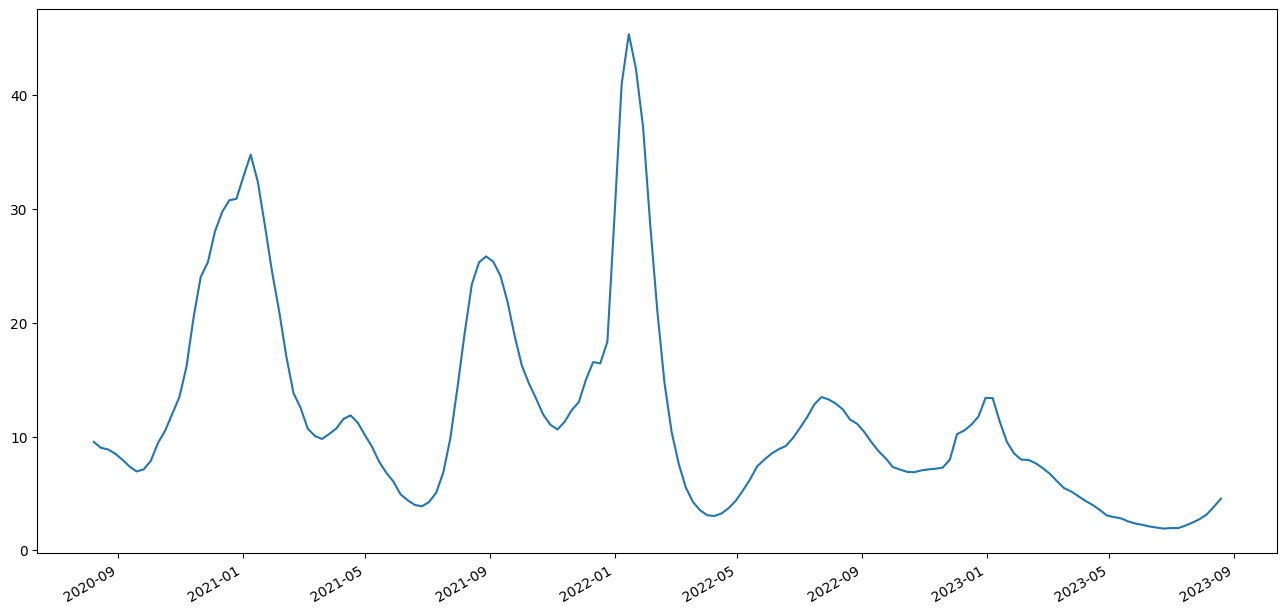

In [143]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(us_data)
fig.autofmt_xdate()

In [15]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

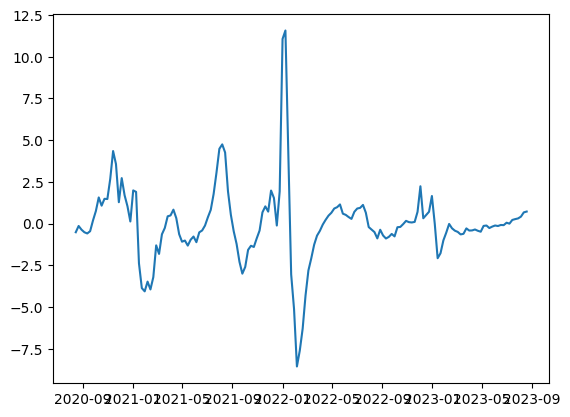

In [16]:
diff_data= us_data.diff()[1:]
plt.plot(diff_data)

In [17]:
ad_fuller_result = adfuller(diff_data)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.319087513227659
p-value: 4.998555391670087e-06


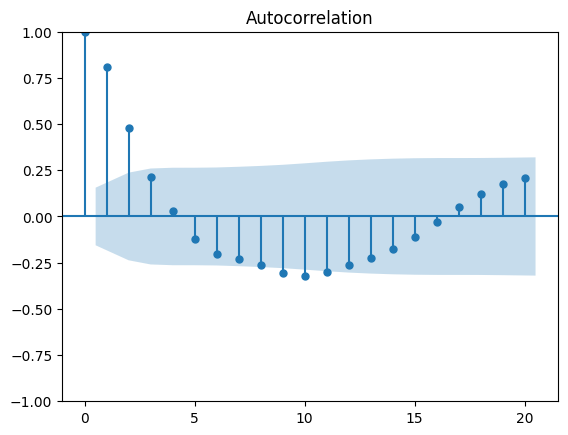

In [18]:
plot_acf(diff_data, lags=20);

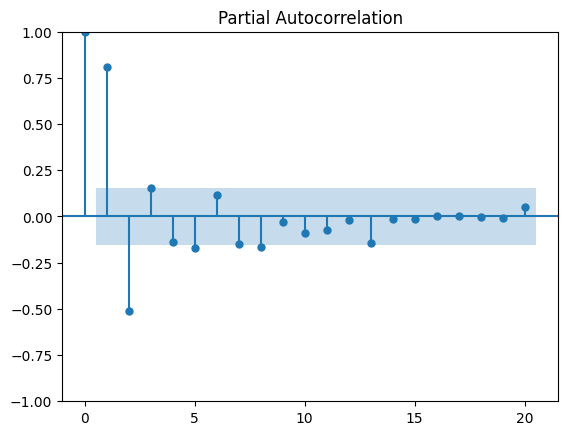

In [19]:
plot_pacf(diff_data, lags = 20, method = 'ywm');

#### Format the data

In [108]:
us_data.tail(24)

week
2023-03-11    6.077547
2023-03-18    5.462805
2023-03-25    5.172451
2023-04-01    4.751980
2023-04-08    4.340244
2023-04-15    3.984230
2023-04-22    3.550507
2023-04-29    3.060761
2023-05-06    2.918897
2023-05-13    2.801129
2023-05-20    2.531257
2023-05-27    2.348431
2023-06-03    2.230964
2023-06-10    2.083378
2023-06-17    1.997537
2023-06-24    1.902057
2023-07-01    1.951755
2023-07-08    1.946032
2023-07-15    2.162291
2023-07-22    2.427947
2023-07-29    2.734866
2023-08-05    3.148710
2023-08-12    3.818873
2023-08-19    4.538131
Name: USA, dtype: float64

In [110]:
train_stop='2023-03-11'
test_start='2023-03-18'
test_stop='2023-08-19'

In [111]:
train=us_data[:train_stop]
test=us_data[test_start:test_stop]
print(train.head())
print(train.tail())
print(test.head())

week
2020-08-08    9.531972
2020-08-15    9.010601
2020-08-22    8.864520
2020-08-29    8.496458
2020-09-05    7.974183
Name: USA, dtype: float64
week
2023-02-11    7.943762
2023-02-18    7.658529
2023-02-25    7.231130
2023-03-04    6.729638
2023-03-11    6.077547
Name: USA, dtype: float64
week
2023-03-18    5.462805
2023-03-25    5.172451
2023-04-01    4.751980
2023-04-08    4.340244
2023-04-15    3.984230
Name: USA, dtype: float64


### Model building and forecast

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [144]:
my_order = (3,1,0)
my_seasonal_order = (2,0,0,10)

Format the training set so it doesn't throw errors

In [145]:
train=train.reset_index(drop=True)
train

0      9.531972
1      9.010601
2      8.864520
3      8.496458
4      7.974183
         ...   
131    7.943762
132    7.658529
133    7.231130
134    6.729638
135    6.077547
Name: USA, Length: 136, dtype: float64

In [146]:
model=SARIMAX(train, order= my_order, seasonal_order=my_seasonal_order, simple_differencing = False)
SARIMA_model=model.fit(disp=False)

In [147]:
print(SARIMA_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                USA   No. Observations:                  136
Model:             SARIMAX(3, 1, 0)x(2, 0, 0, 10)   Log Likelihood                -218.571
Date:                            Sun, 03 Sep 2023   AIC                            449.142
Time:                                    03:04:01   BIC                            466.574
Sample:                                         0   HQIC                           456.226
                                            - 136                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2849      0.082     15.707      0.000       1.125       1.445
ar.L2         -0.7061      0.092   

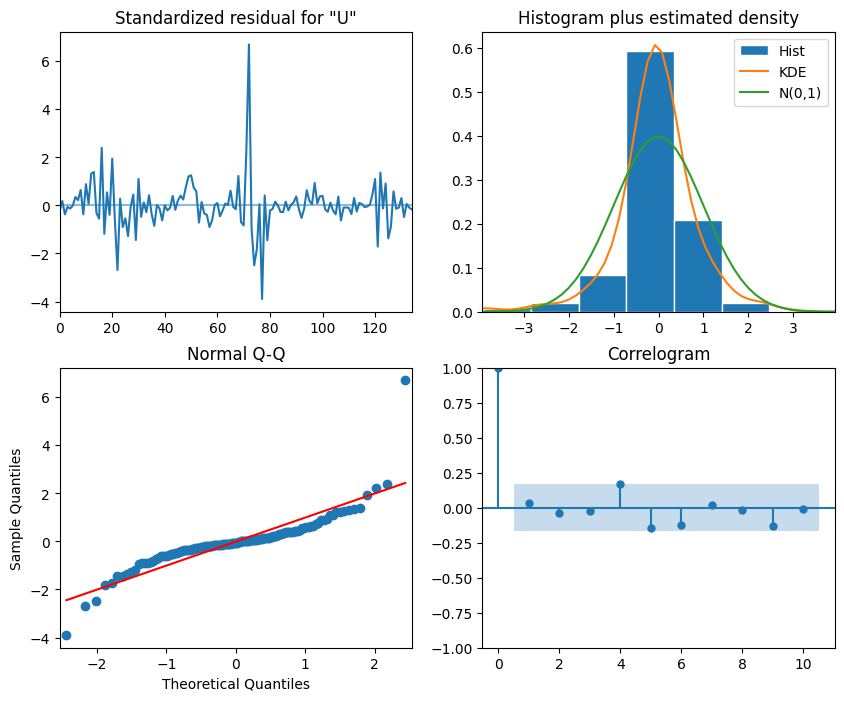

In [148]:
SARIMA_model.plot_diagnostics(figsize= (10,8));

#### Build rolling forecast function

In [149]:
def rolling_forecast(df: pd.DataFrame , train_len: int, horizon: int, window: int) -> list:

    total_len = train_len + horizon

    pred_model = []

    for i in range(train_len, total_len, window):
        model=SARIMAX(df[:i], order= my_order, seasonal_order=my_seasonal_order, simple_differencing = False)
        model_fit=model.fit(disp=False)
        predictions = model_fit.get_prediction(0,i + window - 1)
        oos_predictions=predictions.predicted_mean.iloc[-window:]
        pred_model.extend(oos_predictions)

    return pred_model

In [150]:
model_data=us_data.reset_index(drop=True)

Let's predict for the data we have and see how it matches

In [151]:
train_length = len(train)
horizon = len(test)
window = 2

predictions = rolling_forecast(model_data, train_length, horizon, window)

In [152]:
pred= pd.Series(predictions[1:], index=test.index)
residuals = pd.Series(test - pred, index=test.index)
forecast_df=pd.DataFrame(test)
forecast_df['predictions']=pred
forecast_df['residuals']= residuals
forecast_df=forecast_df.rename(columns ={'USA':'actuals'})

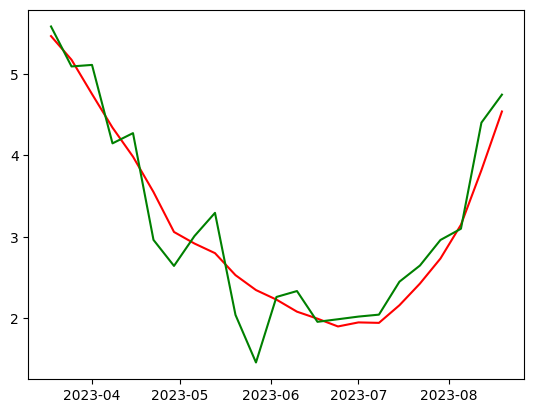

In [153]:
plt.plot(forecast_df['actuals'], 'r-', forecast_df['predictions'],'-g')

In [154]:
MAE = np.mean(abs(residuals))
print('Mean Absolute Error: ', MAE)

Mean Absolute Error:  0.26798774295433436


In [155]:
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error:  0.3441207557571588


In [156]:
print('Mean Absolute Percent Error: ' , round(np.mean(abs(residuals/test)),4))

Mean Absolute Percent Error:  0.0922


In [157]:
total_period= pd.date_range(min(us_data.index), periods = len(us_data)+12, freq = 'W')

In [158]:
train_length = len(train)
horizon = len(total_period) -  len(train)
window = 2

lt_predictions = rolling_forecast(model_data, train_length, horizon, window)

In [159]:
lt_pred= pd.Series(lt_predictions, index=total_period[-(horizon)-1:])

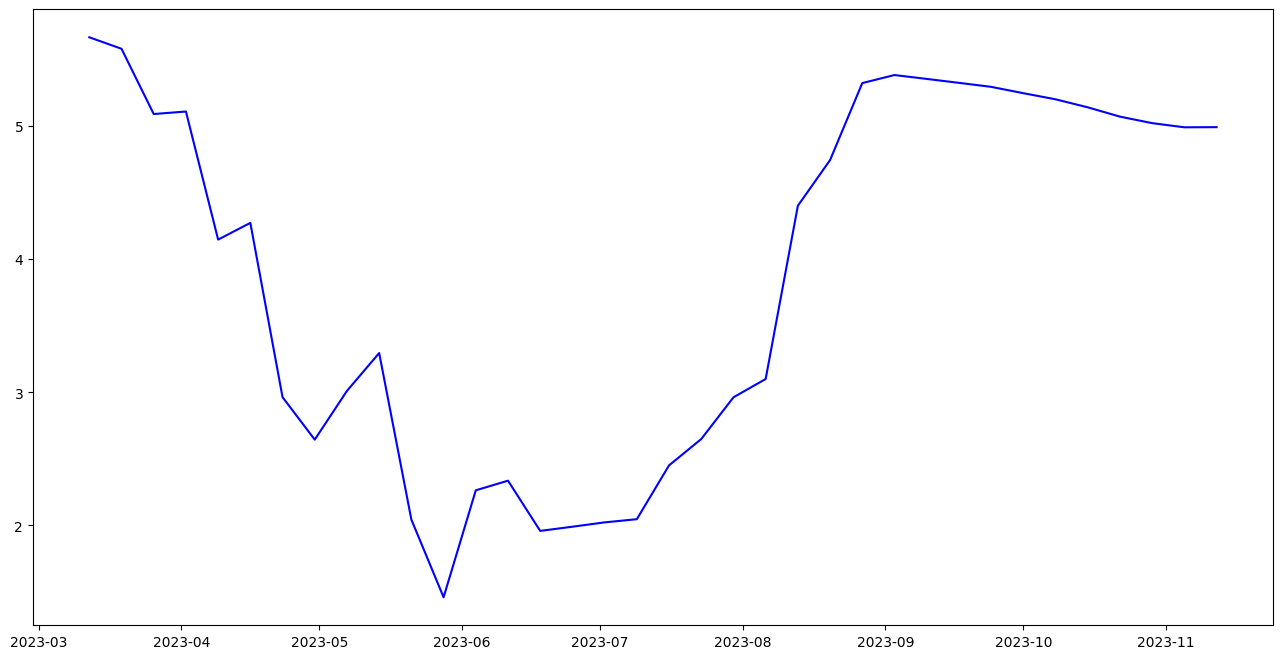

In [160]:
plt.figure(figsize=(16,8))
plt.plot(lt_pred, 'b-')